<a href="https://colab.research.google.com/github/AREAGAM/upgraded-adventure/blob/main/nosie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.spatial import Voronoi
from skimage.draw import polygon
from PIL import Image
!pip install noise
from noise import snoise3

In [25]:
size = 1024
n = 256
map_seed = 762345

In [26]:
np.random.seed(map_seed)

In [27]:
def voronoi(points, size):
    # Add points at edges to eliminate infinite ridges
    edge_points = size*np.array([[-1, -1], [-1, 2], [2, -1], [2, 2]])
    new_points = np.vstack([points, edge_points])
    
    # Calculate Voronoi tessellation
    vor = Voronoi(new_points)
    
    return vor

def voronoi_map(vor, size):
    # Calculate Voronoi map
    vor_map = np.zeros((size, size), dtype=np.uint32)

    for i, region in enumerate(vor.regions):
        # Skip empty regions and infinte ridge regions
        if len(region) == 0 or -1 in region: continue
        # Get polygon vertices    
        x, y = np.array([vor.vertices[i][::-1] for i in region]).T
        # Get pixels inside polygon
        rr, cc = polygon(x, y)
        # Remove pixels out of image bounds
        in_box = np.where((0 <= rr) & (rr < size) & (0 <= cc) & (cc < size))
        rr, cc = rr[in_box], cc[in_box]
        # Paint image
        vor_map[rr, cc] = i

    return vor_map

In [28]:
points = np.random.randint(0, size, (514, 2))
vor = voronoi(points, size)
vor_map = voronoi_map(vor, size)

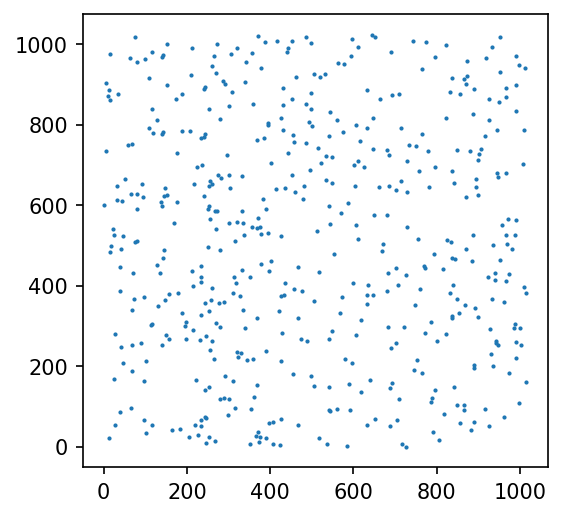

In [29]:
fig = plt.figure(dpi=150, figsize=(4, 4))
plt.scatter(*points.T, s=1)

In [30]:
def relax(points, size, k=10):  
    new_points = points.copy()
    for _ in range(k):
        vor = voronoi(new_points, size)
        new_points = []
        for i, region in enumerate(vor.regions):
            if len(region) == 0 or -1 in region: continue
            poly = np.array([vor.vertices[i] for i in region])
            center = poly.mean(axis=0)
            new_points.append(center)
        new_points = np.array(new_points).clip(0, size)
    return new_points

In [31]:
points = relax(points, size, k=100)
vor = voronoi(points, size)
vor_map = voronoi_map(vor, size)

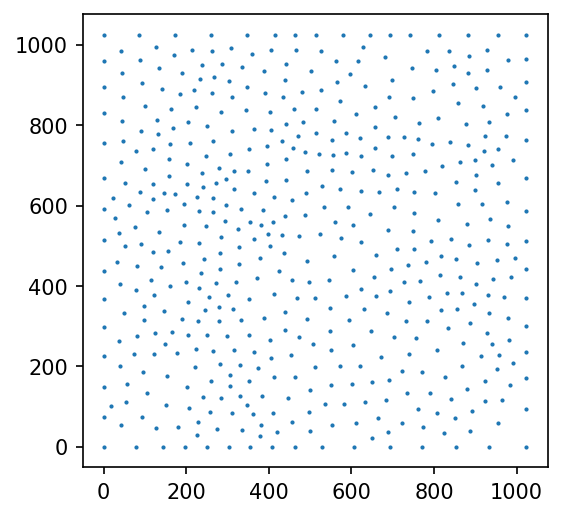

In [32]:
fig = plt.figure(dpi=150, figsize=(4, 4))
plt.scatter(*points.T, s=1)

In [ ]:
#Perlin noise / Simplex noise

In [50]:
def noise_map(size, res, seed, octaves=1, persistence=1, lacunarity=3.0):
    scale = size/res
    return np.array([[
        snoise3(
            (x+0.1)/scale,
            y/scale,
            seed+map_seed,
            octaves=octaves,
            persistence=persistence,
            lacunarity=lacunarity
        )
        for x in range(size)]
        for y in range(size)
    ])

In [51]:
print (noise_map)


<function noise_map at 0x7fc8d44554d0>


In [52]:
boundary_displacement = 8
boundary_noise = np.dstack([noise_map(size, 32, 200, octaves=8), noise_map(size, 32, 250, octaves=8)])
boundary_noise = np.indices((size, size)).T + boundary_displacement*boundary_noise
boundary_noise = boundary_noise.clip(0, size-1).astype(np.uint32)

blurred_vor_map = np.zeros_like(vor_map)

print (blurred_vor_map)

for x in range(size):
    for y in range(size):
        j, i = boundary_noise[x, y]
        blurred_vor_map[x, y] = vor_map[i, j]

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


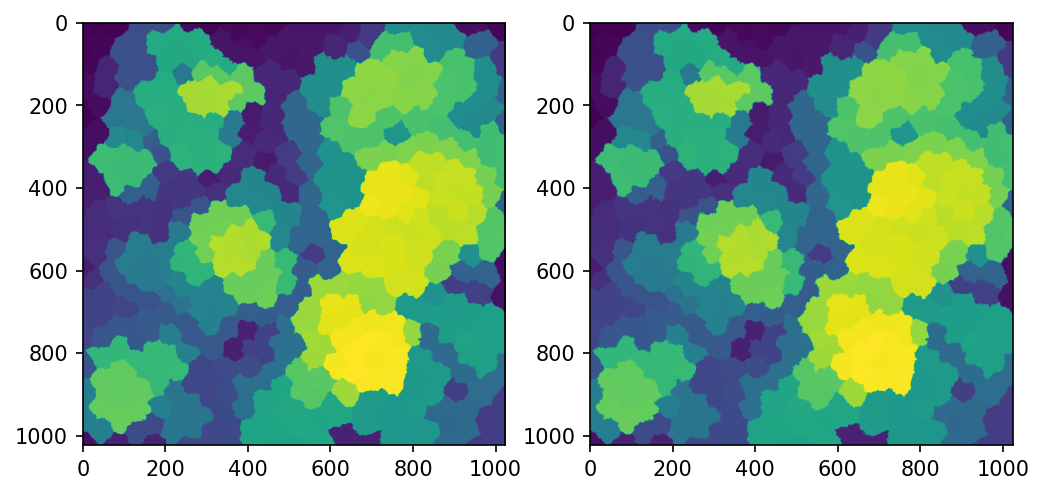

In [53]:
fig, axes = plt.subplots(1, 2)
fig.set_dpi(150)
fig.set_size_inches(8, 4)
axes[0].imshow(vor_map)
axes[1].imshow(blurred_vor_map)

In [38]:
vor_map = blurred_vor_map

In [39]:
#Choosing Biomes
"""Temperature–Precipitation maps"""

'Temperature–Precipitation maps'

In [43]:
temperature_map = noise_map(size, 2, 10)
precipitation_map = noise_map(size, 2, 20)
print(noise_map)

<function noise_map at 0x7fc8d465c710>


Text(0.5, 1.0, 'Precipitation Map')

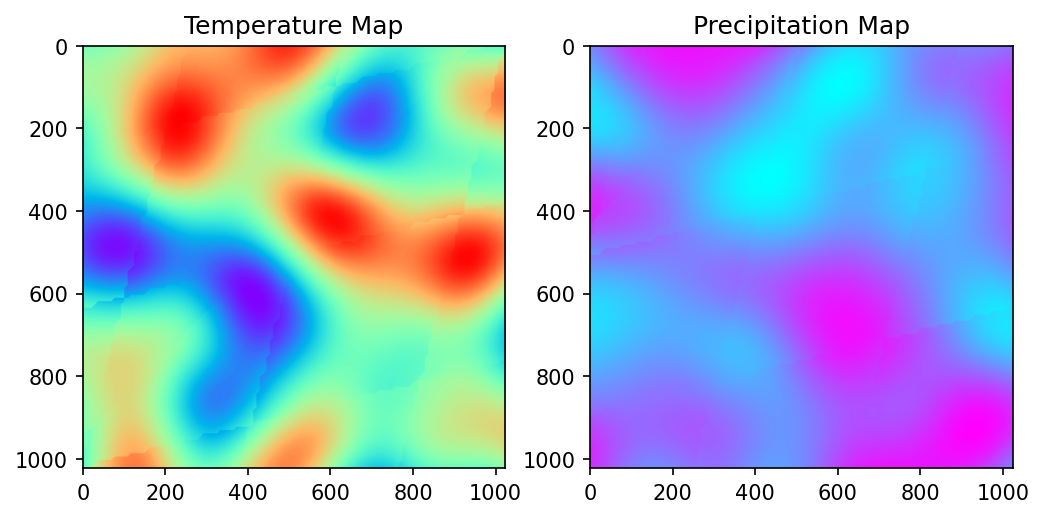

In [42]:
fig, axes = plt.subplots(1, 2)
fig.set_dpi(150)
fig.set_size_inches(8, 4)

axes[0].imshow(temperature_map, cmap="rainbow")
axes[0].set_title("Temperature Map")

axes[1].imshow(precipitation_map, cmap="cool")
axes[1].set_title("Precipitation Map")

[Text(0, 0, '1'),
 Text(0, 0, '0.5'),
 Text(0, 0, '0'),
 Text(0, 0, '-0.5'),
 Text(0, 0, '-1')]

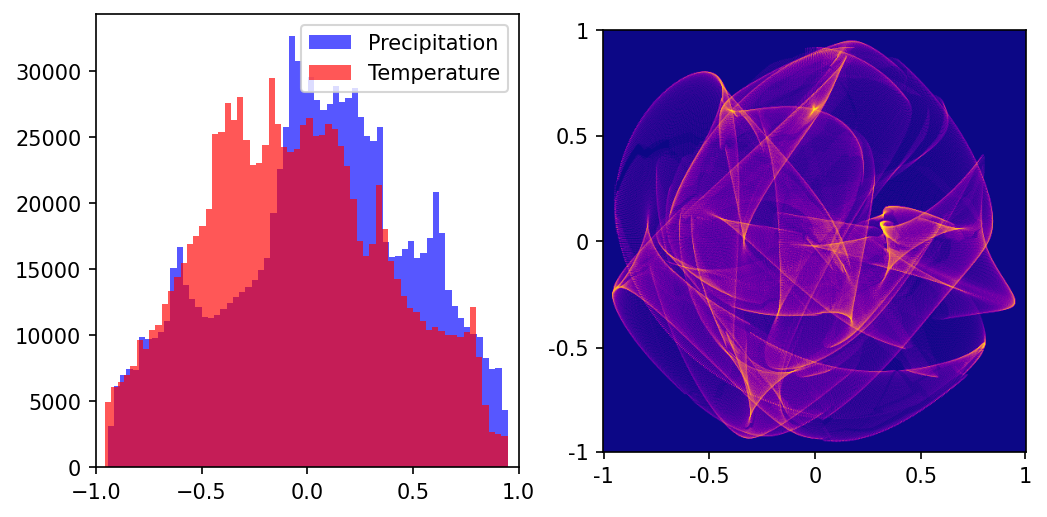

In [54]:
fig, axes = plt.subplots(1, 2)
fig.set_dpi(150)
fig.set_size_inches(8, 4)

axes[0].hist(temperature_map.flatten(), bins=64, color="blue", alpha=0.66, label="Precipitation")
axes[0].hist(precipitation_map.flatten(), bins=64, color="red", alpha=0.66, label="Temperature")
axes[0].set_xlim(-1, 1)
axes[0].legend()

hist2d = np.histogram2d(
    temperature_map.flatten(), precipitation_map.flatten(),
    bins=(512, 512), range=((-1, 1), (-1, 1))
)[0]

from scipy.special import expit
hist2d = np.interp(hist2d, (hist2d.min(), hist2d.max()), (0, 1))
hist2d = expit(hist2d/0.1)

axes[1].imshow(hist2d, cmap="plasma")

axes[1].set_xticks([0, 128, 256, 385, 511])
axes[1].set_xticklabels([-1, -0.5, 0, 0.5, 1])
axes[1].set_yticks([0, 128, 256, 385, 511])
axes[1].set_yticklabels([1, 0.5, 0, -0.5, -1])

In [55]:
from skimage import exposure

def histeq(img,  alpha=1):
    img_cdf, bin_centers = exposure.cumulative_distribution(img)
    img_eq = np.interp(img, bin_centers, img_cdf)
    img_eq = np.interp(img_eq, (0, 1), (-1, 1))
    return alpha * img_eq + (1 - alpha) * img

In [56]:
uniform_temperature_map = histeq(temperature_map, alpha=0.33)
uniform_precipitation_map = histeq(precipitation_map, alpha=0.33)

[Text(0, 0, '1'),
 Text(0, 0, '0.5'),
 Text(0, 0, '0'),
 Text(0, 0, '-0.5'),
 Text(0, 0, '-1')]

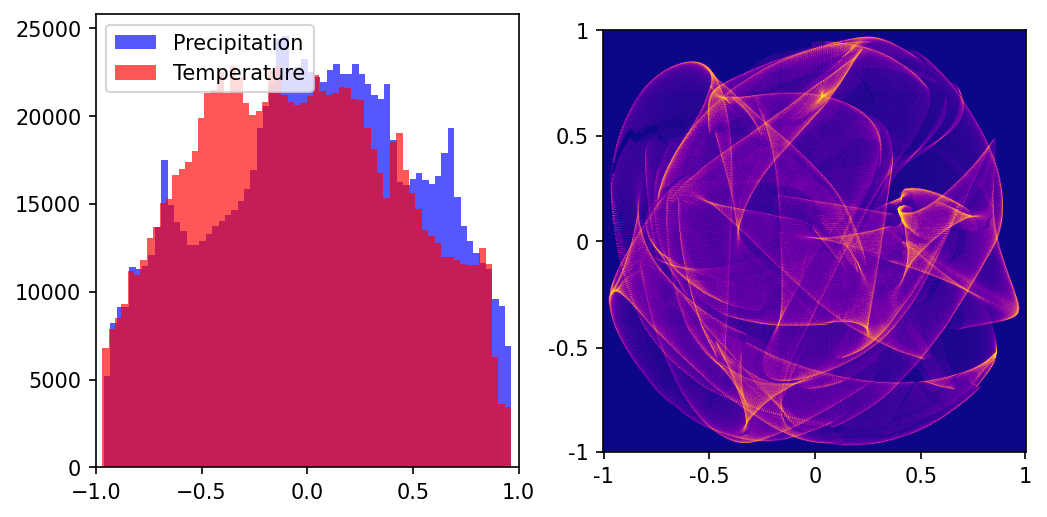

In [57]:
fig, axes = plt.subplots(1, 2)
fig.set_dpi(150)
fig.set_size_inches(8, 4)

axes[0].hist(uniform_temperature_map.flatten(), bins=64, color="blue", alpha=0.66, label="Precipitation")
axes[0].hist(uniform_precipitation_map.flatten(), bins=64, color="red", alpha=0.66, label="Temperature")
axes[0].set_xlim(-1, 1)
axes[0].legend()

hist2d = np.histogram2d(
    uniform_temperature_map.flatten(), uniform_precipitation_map.flatten(),
    bins=(512, 512), range=((-1, 1), (-1, 1))
)[0]

from scipy.special import expit
hist2d = np.interp(hist2d, (hist2d.min(), hist2d.max()), (0, 1))
hist2d = expit(hist2d/0.1)

axes[1].imshow(hist2d, cmap="plasma")

axes[1].set_xticks([0, 128, 256, 385, 511])
axes[1].set_xticklabels([-1, -0.5, 0, 0.5, 1])
axes[1].set_yticks([0, 128, 256, 385, 511])
axes[1].set_yticklabels([1, 0.5, 0, -0.5, -1])

In [58]:
temperature_map = uniform_temperature_map
precipitation_map = uniform_precipitation_map

In [59]:
def average_cells(vor, data):
    """Returns the average value of data inside every voronoi cell"""
    size = vor.shape[0]
    count = np.max(vor)+1

    sum_ = np.zeros(count)
    count = np.zeros(count)

    for i in range(size):
        for j in range(size):
            p = vor[i, j]
            count[p] += 1
            sum_[p] += data[i, j]

    average = sum_/count
    average[count==0] = 0

    return average

def fill_cells(vor, data):
    size = vor.shape[0]
    image = np.zeros((size, size))

    for i in range(size):
        for j in range(size):
            p = vor[i, j]
            image[i, j] = data[p]

    return image

def color_cells(vor, data, dtype=int):
    size = vor.shape[0]
    image = np.zeros((size, size, 3))

    for i in range(size):
        for j in range(size):
            p = vor[i, j]
            image[i, j] = data[p]

    return image.astype(dtype)

In [60]:
temperature_cells = average_cells(vor_map, temperature_map)
precipitation_cells = average_cells(vor_map, precipitation_map)

temperature_map = fill_cells(vor_map, temperature_cells)
precipitation_map = fill_cells(vor_map, precipitation_cells)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


Text(0.5, 1.0, 'Precipitation')

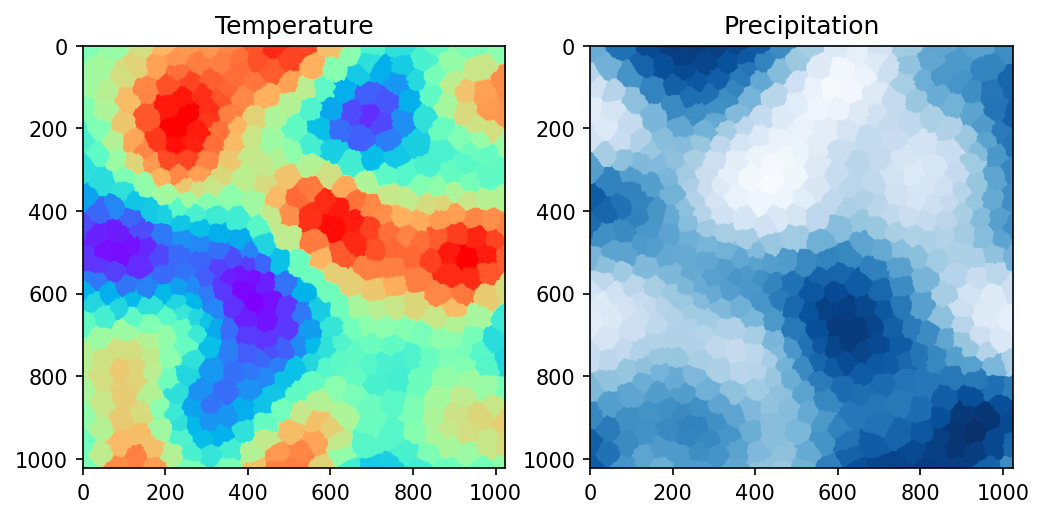

In [61]:
fig, ax = plt.subplots(1 ,2)
fig.set_dpi(150)
fig.set_size_inches(8, 4)

ax[0].imshow(temperature_map, cmap="rainbow")
ax[0].set_title("Temperature")

ax[1].imshow(precipitation_map, cmap="Blues")
ax[1].set_title("Precipitation")

In [63]:
def quantize(data, n):
    bins = np.linspace(-1, 1, n+1)
    return (np.digitize(data, bins) - 1).clip(0, n-1)

n = 256

quantize_temperature_cells = quantize(temperature_cells, n)
quantize_precipitation_cells = quantize(precipitation_cells, n)

quantize_temperature_map = fill_cells(vor_map, quantize_temperature_cells)
quantize_precipitation_map = fill_cells(vor_map, quantize_precipitation_cells)

In [64]:
temperature_cells = quantize_temperature_cells
precipitation_cells = quantize_precipitation_cells

temperature_map = quantize_temperature_map
precipitation_map = quantize_precipitation_map

In [65]:
im = np.array(Image.open("output/TP_map.png"))[:, :, :3]
biomes = np.zeros((256, 256))

biome_names = [
  "desert",
  "savanna",
  "tropical_woodland",
  "tundra",
  "seasonal_forest",
  "rainforest",
  "temperate_forest",
  "temperate_rainforest",
  "boreal_forest"
]
biome_colors = [
  [255, 255, 178],
  [184, 200, 98],
  [188, 161, 53],
  [190, 255, 242],
  [106, 144, 38],
  [33, 77, 41],
  [86, 179, 106],
  [34, 61, 53],
  [35, 114, 94]
]

for i, color in enumerate(biome_colors):
    indices = np.where(np.all(im == color, axis=-1))
    biomes[indices] = i
    
biomes = np.flip(biomes, axis=0).T

FileNotFoundError: ignored

In [66]:
fig = plt.figure(dpi=150, figsize=(4, 4))
plt.imshow(biomes)
plt.title("Temperature–Precipitation graph")

NameError: ignored

<Figure size 600x600 with 0 Axes>